In [1]:
import netCDF4 as nc
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
#import zipfile
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Paths
ddbnetcdf_path = '/home/fuaday/scratch/ncrb-models/MESH-ncrb/MESH_drainage_database.nc'
ncrbshapefile_path = '/scratch/fuaday/ncrb-models/geofabric-outputs/ncrb-geofabric/ncrb_subbasins.shp'
zip_path = '/project/6008034/Climate_Forcing_Data/geospatial-data/HydroLakes/HydroLAKES_polys_v10_shp.zip'
extract_to_path = '/scratch/fuaday/ncrb-models/geofabric-outputs/ncrb-geofabric/HydrolakesV10/HydroLAKES_polys_v10_shp'
## Unzip the lake shapefiles
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_to_path)
# Load lake shapefile (adjust the filename as needed based on contents of the ZIP)
lake_shapefile_path = os.path.join(extract_to_path, 'HydroLAKES_polys_ncrb.shp')
lakes = gpd.read_file(lake_shapefile_path)

# Load and convert CRS of regional shapefile to use for clipping
ncrb_gdf = gpd.read_file(ncrbshapefile_path).to_crs(epsg=4326)
# Convert CRS of lakes to EPSG:4326
clipped_lakes = lakes.to_crs(epsg=4326)
# Clip lakes to the extent of the NCRB shapefile
#clipped_lakes = gpd.clip(lakes, ncrb_gdf)

# Load NetCDF data
dataset = nc.Dataset(ddbnetcdf_path)
subbasin_values = dataset.variables['subbasin'][:]
chnlslope_values = dataset.variables['ChnlSlope'][:]
chnllength_values = dataset.variables['ChnlLength'][:]

landuse_classes = dataset.variables['LandUse'][:]  # array of land use class descriptions
gru_class = dataset.variables['GRU'][:]  # 2D array (subbasin x landuse_class)
dataset.close()

In [2]:
# Prepare NetCDF and shapefile data
gdf = gpd.read_file(ncrbshapefile_path).to_crs(epsg=4326)
gdf['COMID'] = gdf['COMID'].astype(int)

# Create a DataFrame for all extracted data
df = pd.DataFrame({
    'subbasin': subbasin_values,
    'chnlslope': chnlslope_values,
    'chnllength': chnllength_values
})
# Ensure 'subbasin' in both df and gdf are the same type
df['subbasin'] = df['subbasin'].astype(int)

# Append GRU class data as separate columns for each land use class
for i, landuse in enumerate(landuse_classes):
    df[landuse] = gru_class[:, i]  # No need to decode

# print(df.head())

# gdf = gdf.merge(df, left_on='COMID', right_on='subbasin', how='left')
# Merge DataFrame with GeoDataFrame based on 'subbasin'
merged_gdf = gdf.merge(df, left_on='COMID', right_on='subbasin', how='left')

# Check the result
# print(merged_gdf.head())
# Save the merged GeoDataFrame as a new shapefile
# output_path = '/scratch/fuaday/ncrb-models/geofabric-outputs/ncrb_shapefile_drainagedatabase.shp'
# merged_gdf.to_file(output_path)

/tmp/ipykernel_4504/4155577768.py:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gnuplot2_r").copy()
  cmap.set_under('white', alpha=0)


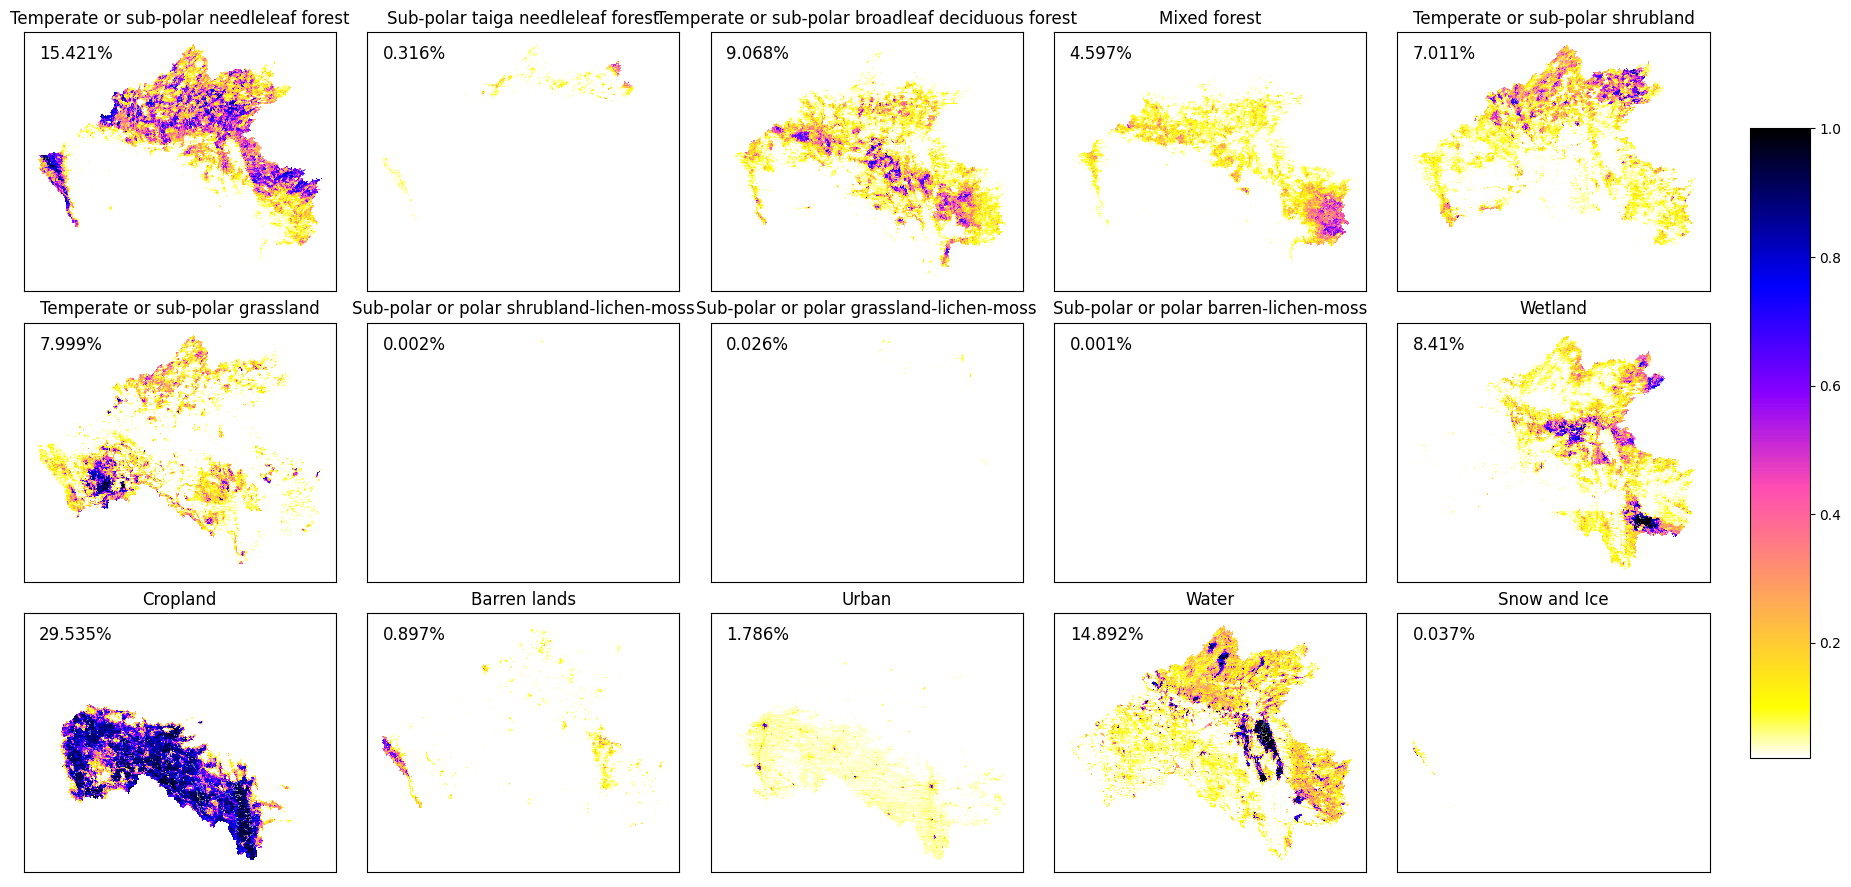

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assume merged_gdf is already prepared and loaded as per your previous code
# Identify the last 16 columns and ignore the last one
gru_columns = merged_gdf.columns[-16:-1]  # Excludes the very last column

# Pre-calculate the percentage values
percentages = [(merged_gdf[col].sum() / len(merged_gdf) * 100) for col in gru_columns]
rounded_percentages = [round(p, 3) for p in percentages]

# Create a modified jet colormap that sets zero values to white
cmap = plt.cm.gnuplot2_r
cmap.set_under('white', alpha=0)
#cmap = plt.cm.jet
#cmap.set_under('white', alpha=0)

# Set up the figure and axes for a 3x5 grid (15 plots)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 9), sharex=True, sharey=True)

# Create an Image for colormap scaling
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=0.02, vmax=1))
sm._A = []  # Fake up the array of the scalar mappable. Urgh...

# Loop through and plot each column
for i, (col, rounded_percentage) in enumerate(zip(gru_columns, rounded_percentages)):
    ax = axes.flatten()[i]
    merged_gdf.plot(column=col, ax=ax, cmap=cmap, vmin=0.01, vmax=1)
    ax.set_title(col, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the pre-calculated percentage with a percentage sign in the top left corner of the subplot
    ax.text(0.05, 0.95, f"{rounded_percentage}%", transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.5))

# Hide any unused subplots
for i in range(len(gru_columns), axes.flatten().shape[0]):
    axes.flatten()[i].set_visible(False)

# Adjust layout
fig.tight_layout(pad=1.0)
fig.subplots_adjust(right=0.85, hspace=0.1, wspace=0.1)

# Place colorbar
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
fig.colorbar(sm, cax=cbar_ax)

# Save the figure if needed
plt.savefig('landuse_gru_plots.png')

# Show the plot
plt.show()

In [ ]:
#for i, col in enumerate(gru_columns):
#    print(col)

In [ ]:
#print(df.head())

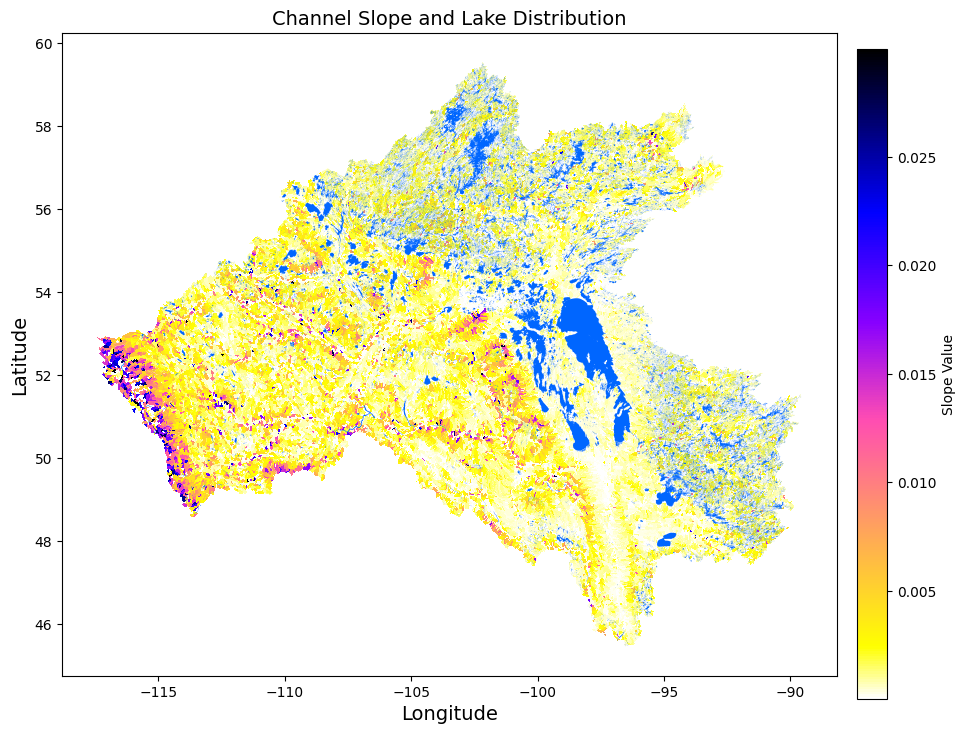

In [4]:
# Modify 'chnlslope' Values
#gdf['chnlslope'] = gdf['chnlslope'].apply(lambda x: 0 if x > 0.025 else x)
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Plot channel slope
viridis_r = plt.cm.get_cmap('gnuplot2').reversed()
slope_mapping = merged_gdf.plot(column='chnlslope', ax=ax, legend=False, vmin=merged_gdf['chnlslope'].min(), vmax=merged_gdf['chnlslope'].max(), cmap=viridis_r)
# Plot lakes
lake_mapping = clipped_lakes.plot(ax=ax, color='#0066FF', alpha=1)
# Manually add colorbar axes with reduced height
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.65])  # Reduced height
colorbar = fig.colorbar(slope_mapping.get_children()[0], cax=cbar_ax, orientation='vertical')
colorbar.set_label('Slope Value')
# Add axis labels and plot title
ax.set_xlabel('Longitude', fontsize=14)  # Assuming appropriate labels for geographic data
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Channel Slope and Lake Distribution', fontsize=14)
# Save the figure
plt.savefig('Channel_Slope_and_Lakes.png', dpi=300)  # Adjust dpi for higher resolution
plt.show()

In [ ]:
!pip install contextily

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Load the subbasins, rivers, and lakes shapefiles
ncrb_subbasins_path = '/scratch/fuaday/J_Core_modeling/Nelson_project/Input_data_NCRB/Input_data_NCRB/NCRB_shapefiles/NCRB_Subbasins.shp'
ncrb_rivers_path = '/scratch/fuaday/J_Core_modeling/Nelson_project/Input_data_NCRB/Input_data_NCRB/NCRB_shapefiles/NCRB_River_75.shp'
ncrb_lakes_path = '/scratch/fuaday/ncrb-models/geofabric-outputs/ncrb-geofabric/HydrolakesV10/HydroLAKES_polys_v10_shp/HydroLAKES_polys_ncrb.shp'
ncrb_subbasins = gpd.read_file(ncrb_subbasins_path)
ncrb_rivers = gpd.read_file(ncrb_rivers_path)
ncrb_lakes = gpd.read_file(ncrb_lakes_path)
# Ensure all data is in the same CRS, here using EPSG:3857
ncrb_subbasins = ncrb_subbasins.to_crs(epsg=3857)
ncrb_rivers = ncrb_rivers.to_crs(epsg=3857)
ncrb_lakes = ncrb_lakes.to_crs(epsg=3857)
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
# Plot subbasins colored by 'MAJ_BAS'
ncrb_subbasins.plot(ax=ax, column='MAJ_BAS', legend=True, cmap='viridis', alpha=0.9)
# Plot rivers in a lighter blue with increased transparency
ncrb_rivers.plot(ax=ax, color='#00B0F0', linewidth=1, alpha=0.9)
# Plot lakes in a lighter '#0066FF' with increased transparency
ncrb_lakes.plot(ax=ax, color='#00B0F0', alpha=0.9)
# Add a basemap
ctx.add_basemap(ax, crs=ncrb_subbasins.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
# Optional: Adjust the legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.5))
leg.set_title('Major Basin', prop={'size': 12})
# Adding labels and titles
ax.set_title('NCRB Subbasins, Rivers, and Lakes', fontsize=16)
ax.axis('off')  # Turn off the axis for a cleaner look
# Save the figure
plt.savefig('NCRB_Subbasins_Rivers_Lakes.png', dpi=300)  # Adjust dpi as needed for quality
plt.show()